# Final Project
by Malte Jörg

---
## 1. Bussiness Problem
- Compare Toronto's and New York's Nightlife
- Bars, Cafés and Restaurants

---
## 2. Data description
- get neighborhood data from the cities
- get venue data via foursquare

Python library imports:

In [185]:
import pandas as pd
import numpy as np
import geocoder
import json
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

---
## 3. Data gathering
- TBD

### a) New York Dataset

In [2]:
# open new york dataset from downloaded json file
with open('data/newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
# only use data from features key
ny_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_ny = pd.DataFrame(columns=column_names)

# put relevant data from features into dataframe
for data in ny_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_ny = df_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
print('Shape of Dataframe: ', df_ny.shape)
df_ny.head()

Shape of Dataframe:  (306, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
print('Unique Neighborhoods in New York: ', len(df_ny['Neighborhood'].unique()))
df_ny.groupby('Borough').count()

Unique Neighborhoods in New York:  302


,Neighborhood,Latitude,Longitude
Borough,,,
Bronx,52,52,52
Brooklyn,70,70,70
Manhattan,40,40,40
Queens,81,81,81
Staten Island,63,63,63


*The New York Dataframe consists of 306 geographical coordinates from 302 unique neighborhoods in 5 boroughs.*

### b) Toronto Dataset

In [5]:
# scraping table from wikipedia url
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df_tor = pd.read_html(url)[0]

In [6]:
# drop not assigned boroughs and rename neighborhoods
df_tor = df_tor[~df_tor['Borough'].isin(['Not assigned'])].reset_index(drop=True)
for i in range(len(df_tor.index)):
    if df_tor['Neighborhood'].loc[i] == 'Not assigned':
       df_tor['Neighborhood'].loc[i] = df_tor['Borough'].loc[i]
    else:
        pass

In [7]:
# get geospatial coordinates from downloaded csv-file and assign to toronto dataframe
df_tor_geo = pd.read_csv('data/Geospatial_Coordinates.csv')
latitude = []
longitude = []
for postal_code in df_tor['Postal Code']:
    i = list(df_tor_geo['Postal Code']).index(postal_code)
    latitude.append(df_tor_geo['Latitude'].loc[i])
    longitude.append(df_tor_geo['Longitude'].loc[i])  
df_tor['Latitude'] = latitude
df_tor['Longitude'] = longitude

In [8]:
# drop postal code column to get consistent dataframe between new york and toronto
df_tor.drop(['Postal Code'], axis=1, inplace=True)

In [9]:
print('Shape of Dataframe: ', df_tor.shape)
df_tor.head()

Shape of Dataframe:  (103, 4)


,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [10]:
print('Unique Neighborhoods in Toronto: ', len(df_tor['Neighborhood'].unique()))
df_tor.groupby('Borough').count()

Unique Neighborhoods in Toronto:  99


,Neighborhood,Latitude,Longitude
Borough,,,
Central Toronto,9,9,9
Downtown Toronto,19,19,19
East Toronto,5,5,5
East York,5,5,5
Etobicoke,12,12,12
Mississauga,1,1,1
North York,24,24,24
Scarborough,17,17,17
West Toronto,6,6,6


*The Toronto Dataframe consists of 103 geographical coordinates from 99 unique neighborhoods in 10 boroughs.*

### c) Examine geographical data in datasets

In [11]:
toronto_lat = 43.651070
toronto_long = -79.347015
map_toronto = folium.Map(location=[toronto_lat, toronto_long], zoom_start=10)
for lat, lng, borough, neighborhoods in zip(df_tor['Latitude'], df_tor['Longitude'], df_tor['Borough'], df_tor['Neighborhood']):
    label = '{}, {}'.format(borough, neighborhoods)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
map_toronto

In [12]:
newyork_lat = 40.730610
newyork_long = -73.935242
map_newyork = folium.Map(location=[newyork_lat, newyork_long], zoom_start=10)
for lat, lng, borough, neighborhoods in zip(df_ny['Latitude'], df_ny['Longitude'], df_ny['Borough'], df_ny['Neighborhood']):
    label = '{}, {}'.format(borough, neighborhoods)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)
map_newyork 

*As you can see already, the new york dataset is much bigger and dense than the Toronto dataset. This points out that a relative analysis of the venues is needed, to get a good comparison of the two cities and the consisting neighborhoods and boroughs.*

In the next step of the data gathering step I will create two dataframes which consist popular venues in the two cities.

### d) New York venue gathering

In [50]:
# foursquare api details:
CLIENT_ID = '5EIRM5SCLCH5CVE5UT23UMXDRFT3MUDM3EZBVTGCW10WALKE'
CLIENT_SECRET = '0AMFGMH3OV3ILQRDA21AMHX23UIIMEZX0EPPLTHIKIWQJ51D'
VERSION = '20200601'
RADIUS = 500
LIMIT = 100

In [63]:
# function to get venues from foursquare by geographical coordinates
def getVenues(borough_names, neighborhood_names, latitudes, longitudes, RADIUS, LIMIT): 
    venues_list=[]

    for bname, nname, lat, lng in zip(borough_names, neighborhood_names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET,  
                lat, 
                lng,
                VERSION, 
                RADIUS, 
                LIMIT)
        req = {}
        print(nname)
        while req == {}:
            req = requests.get(url).json()["response"]  # foursquare request
        results = req['groups'][0]['items']
         
        venues_list.append([(
            bname,
            nname, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        

    venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues.columns = ['Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('done')    
    return(venues)

In [67]:
exec_fsq = False   # execute foursquare api venue exploration

In [64]:
# get new york venues
if exec_fsq == True:
    ny_venues = getVenues(borough_names=df_ny['Borough'],
                                neighborhood_names=df_ny['Neighborhood'],
                                latitudes=df_ny['Latitude'],
                                longitudes=df_ny['Longitude'],
                                RADIUS=RADIUS,
                                LIMIT=LIMIT
                                )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [65]:
# get toronto venues
if exec_fsq == True:
    tor_venues = getVenues(borough_names=df_tor['Borough'],
                                neighborhood_names=df_tor['Neighborhood'],
                                latitudes=df_tor['Latitude'],
                                longitudes=df_tor['Longitude'],
                                RADIUS=RADIUS,
                                LIMIT=LIMIT
                                )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [66]:
# save or read dataframes for later analysis
if exec_fsq == True:
    tor_venues.to_csv('data/toronto_venues.csv')
    ny_venues.to_csv('data/newyork_venues.csv')
else:
    tor_venues = pd.read_csv('data/toronto_venues.csv', index_col=0)
    ny_venues = pd.read_csv('data/newyork_venues.csv', index_col=0)
print('Shape of Toronto venues Dataframe: ', tor_venues.shape)
print('Shape of New York venues Dataframe: ', ny_venues.shape)


Shape of Toronto venues Dataframe:  (2127, 8)
Shape of New York venues Dataframe:  (10005, 8)


*This concludes the data gathering step of this project. There are 2127 venues in the Toronto dataset and 10005 venues in the New York dataset. In the following step these datasets has to be preprocessed to prepare the date for further analysis.*

---
## 4. Data Preprocessing
- Examination of the datasets
- Deleting multiple venues in the dataset
- Merge similar venue categories

### a) Examination

In [68]:
tor_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,North York,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,North York,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,North York,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,North York,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [69]:
print('Total amount of venues in the dataset: ', len(tor_venues.index))
print('Total amount of unique venues in the dataset: ', len(tor_venues['Venue'].unique()))

Total amount of venues in the dataset:  2127
Total amount of unique venues in the dataset:  1389


In [70]:
print('Total amount of unique venue categories in the dataset: ', len(tor_venues['Venue Category'].unique()))
print('List of unqiue venue Categories:')
tor_venues['Venue Category'].unique()

Total amount of unique venue categories in the dataset:  268
List of unqiue venue Categories:


array(['Park', 'Food & Drink Shop', 'Hockey Arena',
       'Portuguese Restaurant', 'Coffee Shop', 'Intersection', 'Bakery',
       'Distribution Center', 'Spa', 'Pub', 'Restaurant',
       'Breakfast Spot', 'Gym / Fitness Center', 'Historic Site',
       'Farmers Market', 'Performing Arts Venue', 'Chocolate Shop',
       'Dessert Shop', 'French Restaurant', 'Café', 'Yoga Studio',
       'Theater', 'Event Space', 'Shoe Store', 'Ice Cream Shop',
       'Art Gallery', 'Cosmetics Shop', 'Asian Restaurant',
       'Electronics Store', 'Bank', 'Beer Store', 'Wine Shop',
       'Antique Shop', 'Boutique', 'Furniture / Home Store',
       'Vietnamese Restaurant', 'Clothing Store', 'Accessories Store',
       'Miscellaneous Shop', 'Carpet Store', 'Italian Restaurant',
       'Sushi Restaurant', 'Creperie', 'Beer Bar', 'Arts & Crafts Store',
       'Burrito Place', 'Mexican Restaurant', 'Hobby Shop', 'Diner',
       'Fried Chicken Joint', 'Discount Store', 'Smoothie Shop',
       'Sandwich Plac

In [71]:
ny_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Bronx,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
2,Bronx,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Bronx,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Bronx,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [72]:
print('Total amount of venues in the dataset: ', len(ny_venues.index))
print('Total amount of unique venues in the dataset: ', len(ny_venues['Venue'].unique()))

Total amount of venues in the dataset:  10005
Total amount of unique venues in the dataset:  7725


In [73]:
print('Total amount of unique venue categories in the dataset: ', len(ny_venues['Venue Category'].unique()))
print('List of unqiue venue Categories:')
ny_venues['Venue Category'].unique()

Total amount of unique venue categories in the dataset:  425
List of unqiue venue Categories:


array(['Dessert Shop', 'Pharmacy', 'Ice Cream Shop', 'Donut Shop',
       'Gas Station', 'Sandwich Place', 'Food', 'Laundromat',
       'Pizza Place', 'Discount Store', 'Post Office', 'Bagel Shop',
       'Grocery Store', 'Fast Food Restaurant', 'Restaurant',
       'Baseball Field', 'Deli / Bodega', 'Trail', 'Park', 'Bus Station',
       'Supermarket', 'Caribbean Restaurant', 'Diner',
       'Seafood Restaurant', 'Bowling Alley', 'Business Service',
       'Food & Drink Shop', 'Platform', 'Metro Station',
       'Convenience Store', 'Bus Stop', 'Cosmetics Shop', 'Plaza',
       'River', 'Bank', 'Home Service', 'Gym', 'Gourmet Shop',
       'Latin American Restaurant', 'Pub', 'Burger Joint', 'Beer Bar',
       'Warehouse Store', 'Coffee Shop', 'Spanish Restaurant',
       'Mexican Restaurant', 'Bar', 'Wings Joint',
       'Thrift / Vintage Store', 'Bakery', 'Candy Store', 'Café',
       'Rental Car Location', 'Fried Chicken Joint', 'Breakfast Spot',
       'Mattress Store', 'Pet Store'

*The Examination of the datasets shows a vast diversity of the venue categories. To get a better understanding of the boroughs in Toronto and New York, a more clear categorization of the venues is decisive.*

### b) Drop multiple venues

In [74]:
# drop multiple venues in dataset by venue coordinates, name and borough
def dropVenues(df):
    del_list = []
    for i in range(len(df.index)):
        coor = [df['Venue Latitude'][i], df['Venue Longitude'][i]]
        venue = df['Venue'][i]
        bor = df['Borough'][i]
        for v in range(i+1,len(df.index)):
            if df['Venue Latitude'][v] == coor[0] and df['Venue Longitude'][v] == coor[1] and df['Venue'][v] == venue and df['Borough'][v] == bor:
                del_list.append(v)
    
    df.drop(del_list, inplace=True)
    return(df.reset_index(drop=True))

In [75]:
tor_venues = dropVenues(tor_venues)
print('Shape of Toronto venues Dataframe: ', tor_venues.shape)

Shape of Toronto venues Dataframe:  (1700, 8)


In [76]:
ny_venues = dropVenues(ny_venues)
print('Shape of New York venues Dataframe: ', ny_venues.shape)

Shape of New York venues Dataframe:  (9458, 8)


In [89]:
exec_drop = False

In [173]:
# save or read dataframes for later analysis
if exec_drop == True:
    tor_venues.to_csv('data/toronto_venues_drop.csv')
    ny_venues.to_csv('data/newyork_venues_drop.csv')
else:
    tor_venues = pd.read_csv('data/toronto_venues_drop.csv', index_col=0)
    ny_venues = pd.read_csv('data/newyork_venues_drop.csv', index_col=0)

*The amount of venues that got drop from the datasets is lower than the amount of unqiue venues. This is possible because a venues could possibly exist in multiple boroughs, because of the radius assigned to the foursquare exploration. The further analysis is continued with this dataset and it is assumed that these venues consist to each of these boroughs.*

### c) Merge venue categories

In [79]:
cat_url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION)
cat_request = requests.get(cat_url).json()

In [80]:
main = []
cate = []
for main_cat in cat_request['response']['categories']:
    for sec_cat in main_cat['categories']:
        main.append(main_cat['name'])
        cate.append(sec_cat['name'])
        for thi_cat in sec_cat['categories']:
            main.append(main_cat['name'])
            cate.append(thi_cat['name'])
            for fou_cat in thi_cat['categories']:
                main.append(main_cat['name'])
                cate.append(fou_cat['name'])
                for fit_cat in fou_cat['categories']:
                    main.append(main_cat['name'])
                    cate.append(fit_cat['name'])
categories = pd.DataFrame()
categories['Main Category'] = main
categories['Category'] = cate
categories.head()

,Main Category,Category
0,Arts & Entertainment,Amphitheater
1,Arts & Entertainment,Aquarium
2,Arts & Entertainment,Arcade
3,Arts & Entertainment,Art Gallery
4,Arts & Entertainment,Bowling Alley


In [167]:
def addMainCategory(df):
    for v in range(len(df.index)):
        i = []
        mask = categories == df['Venue Category'][v]
        i.extend(list(mask[mask['Main Category'] == True].index))
        i.extend(list(mask[mask['Category'] == True].index))
        df['Venue Category'][v] = categories['Main Category'][i[0]]
    print('done')
    return(df)      

In [174]:
tor_venues = addMainCategory(tor_venues)
ny_venues = addMainCategory(ny_venues)

done
done


In [208]:
exec_cat = True

In [210]:
# save or read dataframes for later analysis
if exec_cat == True:
    tor_venues.to_csv('data/toronto_venues_cat.csv')
    ny_venues.to_csv('data/newyork_venues_cat.csv')
else:
    tor_venues = pd.read_csv('data/toronto_venues_cat.csv', index_col=0)
    ny_venues = pd.read_csv('data/newyork_venues_cat.csv', index_col=0)

---
## 5. Data Analysis
- Venue category examination of the cities

In [211]:
tor_venues_count = tor_venues.groupby('Venue Category').count().sort_values(by=['Borough'], ascending=False)
ny_venues_count = ny_venues.groupby('Venue Category').count().sort_values(by=['Borough'], ascending=False)

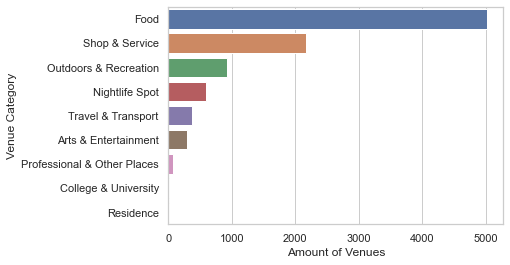

In [212]:
sns.set(style="whitegrid")
ax = sns.barplot(x='Venue', y=ny_venues_count.index, data=ny_venues_count)
ax.set_xlabel('Amount of Venues')
plt.show()

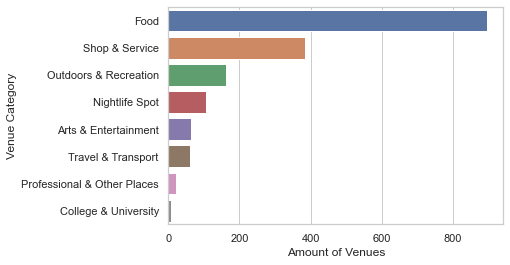

In [213]:
sns.set(style="whitegrid")
ax = sns.barplot(x='Venue', y=tor_venues_count.index, data=tor_venues_count)
ax.set_xlabel('Amount of Venues')
plt.show()

*The statistics show that there is a majority of Food venues, followed by Shops and Services. In comparison it shows that the partitioning of the venue categories is nearly the same in both cities, wheareas there are no Residences in the Toronto data.*

In [214]:
tor_venues_bor = tor_venues.groupby('Borough').count().sort_values(by=['Venue'], ascending=False)
ny_venues_bor = ny_venues.groupby('Borough').count().sort_values(by=['Venue'], ascending=False)

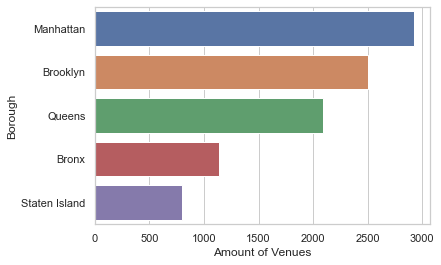

In [217]:
sns.set(style="whitegrid")
ax = sns.barplot(x='Venue', y=ny_venues_bor.index, data=ny_venues_bor)
ax.set_xlabel('Amount of Venues')
plt.show()

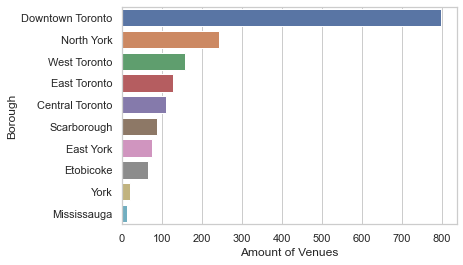

In [216]:
sns.set(style="whitegrid")
ax = sns.barplot(x='Venue', y=tor_venues_bor.index, data=tor_venues_bor)
ax.set_xlabel('Amount of Venues')
plt.show()

*The plots show the amount of venues belonging to a borough in both of the cities. New York is a more equal spreaded, where Manhatten, Brooklyn and Queens have the majority of the venues in the dataset. Toronto is extremely based on its Downtown venues, followed by North York with a large gap. This is an important information for further analysis. There should be an acceptible amount of venues in each borogh.*

In [218]:
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")
tor_onehot['Borough'] = tor_venues['Borough']
tor_fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[tor_fixed_columns]
tor_onehot.head()

,Borough,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,North York,0,0,0,0,1,0,0,0
1,North York,0,0,0,0,0,0,1,0
2,North York,1,0,0,0,0,0,0,0
3,North York,0,0,1,0,0,0,0,0
4,North York,0,0,1,0,0,0,0,0


In [219]:
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")
ny_onehot['Borough'] = ny_venues['Borough']
ny_fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[ny_fixed_columns]
ny_onehot.head()

,Borough,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Bronx,0,0,1,0,0,0,0,0,0
1,Bronx,0,0,0,0,0,0,0,1,0
2,Bronx,0,0,1,0,0,0,0,0,0
3,Bronx,0,0,0,0,0,0,0,1,0
4,Bronx,0,0,1,0,0,0,0,0,0


In [220]:
tor_grouped = tor_onehot.groupby('Borough').mean().reset_index()
ny_grouped = ny_onehot.groupby('Borough').mean().reset_index()
print('Shape of Toronto grouped dataframe: ', tor_grouped.shape)
print('Shape of New York grouped dataframe: ', ny_grouped.shape)

Shape of Toronto grouped dataframe:  (10, 9)
Shape of New York grouped dataframe:  (5, 10)


In [231]:
tor_grouped

,Borough,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Central Toronto,0.027027,0.000000,0.531532,0.045045,0.144144,0.009009,0.207207,0.036036
1,Downtown Toronto,0.056391,0.006266,0.560150,0.073935,0.075188,0.018797,0.166667,0.042607
2,East Toronto,0.007812,0.000000,0.539062,0.093750,0.125000,0.007812,0.210938,0.015625
3,East York,0.000000,0.000000,0.394737,0.026316,0.157895,0.000000,0.394737,0.026316
4,Etobicoke,0.000000,0.000000,0.484848,0.030303,0.121212,0.000000,0.333333,0.030303
5,Mississauga,0.000000,0.000000,0.666667,0.000000,0.083333,0.000000,0.083333,0.166667
6,North York,0.020492,0.000000,0.479508,0.020492,0.086066,0.008197,0.364754,0.020492
7,Scarborough,0.011364,0.011364,0.500000,0.022727,0.102273,0.011364,0.250000,0.090909
8,West Toronto,0.050633,0.000000,0.550633,0.113924,0.069620,0.006329,0.202532,0.006329
9,York,0.052632,0.000000,0.210526,0.105263,0.368421,0.000000,0.210526,0.052632


In [232]:
ny_grouped

,Borough,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Bronx,0.014047,0.000000,0.532924,0.030729,0.076383,0.006146,0.000000,0.289728,0.050044
1,Brooklyn,0.034703,0.000000,0.526526,0.076586,0.092940,0.005983,0.000798,0.242521,0.019944
2,Manhattan,0.046854,0.001710,0.530780,0.079343,0.120383,0.013338,0.001026,0.178523,0.028044
3,Queens,0.013869,0.001435,0.553324,0.053563,0.089431,0.003348,0.000478,0.237685,0.046868
4,Staten Island,0.027604,0.000000,0.481807,0.032622,0.075282,0.005019,0.001255,0.265997,0.110414
